## RT Tools (RADMC-3D)

In [ ]:
import os
import subprocess
import shutil
import numpy as np
import astropy.units as u
import astropy.constants as const
from fargo3d.data import Data


# Parameters
DIR         = r"/cluster/home/jamiechang917/research/disk/simulation/fargo3d/outputs/dustydisk3d_new"
SNAP        = 1000
N_DUST      = 1
UNIT_LENGTH = 100*u.au
UNIT_MASS   = 1*u.solMass

snap_dir = DIR
output_dir = os.path.join(os.getcwd(), "rt_output")
data = Data(snap_dir, snap=SNAP, n_dust=N_DUST, unit_length=UNIT_LENGTH, unit_mass=UNIT_MASS)

Useful Information for Molecules

emission line | frequency | abundance
--- | --- | ---
12CO J=2-1 | 230.538 GHz | 230538 MHz |$1.4\times 10^{-4}$
13CO J=2-1 | 220.398 GHz | 220398.70056 MHz | $4.0\times 10^{-6}$
C18O J=2-1 | 219.560 GHz | 219560.357 MHz | $5.0\times 10^{-7}$

In [1]:
r3d_params = {
    'mstar':      1.0,                  # Mass of the star [Msun]
    'rstar':      2.9,                  # Radius of the star [Rsun]
    'tstar':      4000,                 # Effective temperature of the star [K]
    'pstar':      [0.0, 0.0, 0.0],      # Position of the star [cartesian coordinates] [cm]
    'nw':         [20, 100, 30],        # Number of points in the wavelength grid
    'wbound':     [0.1, 7.0, 25., 1e4], # Boundraries for the wavelength grid
    'dust_nspec': 1,                    # Number of dust species

    'gasspec_mol_abun': 5.0*1e-7,       # Abundance of the molecule (CO 1.4x1e-4, 13CO 4x1e-6, C18O 5x1e-7)
    'gasspec_mol_name': 'c18o',         # Name of the molecule (co, 13co, c18o)

    'lines_mode': 1,                    # 1: LTE, 2: User-defined, 3: Non-LTE, 4: Optical-thin Non-LTE
    'nphot': 1e8,                       # Number of photons 1e8
    'nphot_scat': 1e7,                  # Number of photons for scattering 1e7
    'nphot_spec': 1e7,                  # Number of photons for spectrum
    'scattering_mode_max': 0,           # 0: no scattering, 1: isotropic scattering, 2: anisotropic scattering
    'tgas_eq_tdust': 1,                 # 0: no, 1: yes (take the dust temperature to identical to the gas temperature)
    
    # 'gasspec_vturb': 0.0, # 0.2e5 Microturbulent velocity [cm/s]
    # 'dusttogas': 0.01, # Dust-to-gas mass ratio
    # 'gasspec_mol_freezeout_dfact': 1e-3, #1e-3 Depletion factor of the molecule in the freeze-out region
    # 'gasspec_mol_freezeout_temp': 19.0, # Freeze-out temperature of the molecule [K]
}


rt_params = {
    'threads': 16,
    'iline': 2,
    'widthkms': 6.0,
    'linenlam': 120,
    'vkms': 0.0,
    'npix': 1000,
    'incl': 135,
    'posang': 45,
    'phi': 45,
    'dpc': 100.0,
    'nu0': 219560.357 * 1e6, # Hz
    'sizeau': 1300,
}

if r3d_params['gasspec_mol_name'] == 'co' and rt_params['iline'] == 2:
    r3d_params['gasspec_mol_abun'] = 1.4e-4
    rt_params['nu0'] = 230.538 * 1e9
elif r3d_params['gasspec_mol_name'] == '13co' and rt_params['iline'] == 2:
    r3d_params['gasspec_mol_abun'] = 4e-6
    rt_params['nu0'] = 220398.70056 * 1e6
elif r3d_params['gasspec_mol_name'] == 'c18o' and rt_params['iline'] == 2:
    r3d_params['gasspec_mol_abun'] = 5e-7
    rt_params['nu0'] = 219560.357 * 1e6
else:
    pass

## Generate Input Files

In [3]:
# check output folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
os.chdir(output_dir)

# remove existing files
if len(os.listdir(output_dir)) > 0:
    print("Removing existing files ...\n")
    for f in os.listdir(output_dir):
        if f.endswith(".inp"):
            os.remove(f)

# write amr_grid.inp
with open("amr_grid.inp", "w") as f:
    print("Writing amr_grid.inp ...")
    f.write(f"1\n")              # format number, typically 1
    f.write(f"0\n")              # grid style (regular = 0)
    f.write(f"100\n")            # coordinate system (cartesian: coord < 100, spherical: 100 <= coord < 200)
    f.write(f"0\n")              # grid info (0: no grid info, 1: grid info), typically 0
    f.write(f"1 1 1\n")          # activate the grid (1: activate, 0: deactivate)
    f.write(f"{data.coords['domain_y'].size-1} {data.coords['domain_z'].size-1} {data.coords['domain_x'].size-1}\n") # rad, coalt, azi
    for r in data.coords['domain_y']:     # radius
        f.write(f"{r.to('cm').value:e}\n")
    for theta in data.coords['domain_z']: # colatitude
        f.write(f"{theta.to('rad').value:e}\n")
    for phi in data.coords['domain_x']:   # azimuth
        phi += np.pi * u.rad              # radmc3d only accept phi >= 0
        f.write(f"{phi.to('rad').value:e}\n")

# write stars.inp
with open("stars.inp", "w") as f:
    print("Writing stars.inp ...")
    lambda_points = []
    for i in range(len(r3d_params['nw'])):
        bounds = np.log10(r3d_params['wbound'][i:i+2])
        points = np.linspace(bounds[0], bounds[1], r3d_params['nw'][i], endpoint=(i == len(r3d_params['nw'])-1))
        lambda_points.extend(10**points)
    lambda_points.append(-r3d_params['tstar'])
    f.write(f"2\n1 {np.sum(r3d_params['nw'])}\n")
    f.write(f"{r3d_params['rstar']*u.R_sun.to('cm'):e} {r3d_params['mstar']*const.M_sun.to('g').value:e} {r3d_params['pstar'][0]:e} {r3d_params['pstar'][1]:e} {r3d_params['pstar'][2]:e}\n")
    for point in lambda_points:
        f.write(f"{point:e}\n")

# write wavelength_micron.inp
with open("wavelength_micron.inp", "w") as f:
    print("Writing wavelength_micron.inp ...")
    lambda_points = []
    for i in range(len(r3d_params['nw'])):
        bounds = np.log10(r3d_params['wbound'][i:i+2])
        points = np.linspace(bounds[0], bounds[1], r3d_params['nw'][i], endpoint=(i == len(r3d_params['nw'])-1))
        lambda_points.extend(10**points)
    lambda_points = np.array(lambda_points)
    f.write(f"{int(np.sum(r3d_params['nw']))}\n")
    for point in lambda_points:
        f.write(f"{point:.9e}\n")

# write dust_density.inp
with open("dust_density.inp", "w") as f:
    print("Writing dust_density.inp ...")
    n_cells = data.coords['sph_r'].size * data.coords['sph_theta'].size * data.coords['sph_phi'].size
    n_spec  = r3d_params['dust_nspec']
    f.write(f"1\n")         # format number, typically 1
    f.write(f"{n_cells}\n") # number of cells
    f.write(f"{n_spec}\n")  # number of dust species

    for i in range(1, n_spec+1):
        fluid_density = data.fluids["density"][f"dust{i}"].to('g/cm^3').value
        # transpose the array to match the radmc3d format (rad, colat, azi)
        fluid_density = np.transpose(fluid_density, (1, 0, 2)).ravel(order='F') # Fortran order
        fluid_density.tofile(f, sep="\n", format="%13.6e")
        f.write("\n")

# write numberdens_mol.inp
with open(f"numberdens_{r3d_params['gasspec_mol_name']}.inp", "w") as f:
    print(f"Writing numberdens_{r3d_params['gasspec_mol_name']}.inp ...")
    factor = r3d_params['gasspec_mol_abun'] / (2.3 * const.m_p.to('g').value) # mass of proton = 1.6726e-24 g
    n_cells = data.coords['sph_r'].size * data.coords['sph_theta'].size * data.coords['sph_phi'].size
    f.write(f"1\n")         # format number, typically 1
    f.write(f"{n_cells}\n") # number of cells
   
    gas_density = data.fluids["density"][f"gas"].to('g/cm^3').value
    # transpose the array to match the radmc3d format (rad, colat, azi)
    gas_density = np.transpose(gas_density, (1, 0, 2)).ravel(order='F') # Fortran order
    gas_number_density = gas_density * factor
    gas_number_density.tofile(f, sep="\n", format="%13.6e")
    f.write("\n")

# write gas_velocity.inp
with open("gas_velocity.inp", "w") as f:
    print("Writing gas_velocity.inp ...")
    n_cells = data.coords['sph_r'].size * data.coords['sph_theta'].size * data.coords['sph_phi'].size
    f.write(f"1\n")         # format number, typically 1
    f.write(f"{n_cells}\n") # number of cells

    gas_vel_sph_r     = data.fluids["velocity"]["gas"]["sph_r"].to('cm/s').value
    gas_vel_sph_theta = data.fluids["velocity"]["gas"]["sph_theta"].to('cm/s').value
    gas_vel_sph_phi   = data.fluids["velocity"]["gas"]["sph_phi"].to('cm/s').value

    # print("TESTING SETUP")
    # mask = (data.mesh['sph_r'] < 100*u.au) & (data.mesh['sph_r'] > 50*u.au)
    # gas_vel_sph_phi[mask] *= 0.5
    # mask = (data.mesh['sph_r'] < 150*u.au) & (data.mesh['sph_r'] >= 100*u.au)
    # gas_vel_sph_phi[mask] *= 1.5

    data_lines = [
        f"{gas_vel_sph_r[itheta, irad, iphi]:13.6e} {gas_vel_sph_theta[itheta, irad, iphi]:13.6e} {gas_vel_sph_phi[itheta, irad, iphi]:13.6e}\n"
        for iphi   in range(data.coords['sph_phi'].size)
        for itheta in range(data.coords['sph_theta'].size)
        for irad   in range(data.coords['sph_r'].size)
    ]
    f.writelines(data_lines)
    f.write("\n")

# write lines.inp
with open("lines.inp","w") as f:
    print("Writing lines.inp ...")
    f.write("1\n")  # format number, typically 1
    f.write("1\n")  # number of molecules to be modeled
    f.write(f"{r3d_params['gasspec_mol_name']}    leiden    0    0\n")

# write dustopac.inp
with open("dustopac.inp", "w") as f:
    print("Writing dustopac.inp ...")
    f.write(f"2\n") # format number, typically 2
    f.write(f"{r3d_params['dust_nspec']}\n") # number of dust species
    f.write("============================================================================\n")
    f.write(f"1\n") # 1: use the dustkappa_*.inp input file style, 10: use the dustkapscatmat_*.inp input file style
    f.write(f"0\n") # 0: normal thermal grain, non-zero value: quantum-heated grain (not supported yet)
    f.write(f"silicate\n") # extension of name of dustkappa_***.inp file
    f.write("----------------------------------------------------------------------------\n")

# write dustkappa_silicate.inp
print("Writing dustkappa_silicate.inp ...")
shutil.copyfile(f"../radmc3d/opac/dustkappa_silicate.inp", "dustkappa_silicate.inp")

# write molecule.inp
print(f"Writing molecule_{r3d_params['gasspec_mol_name']}.inp ...")
shutil.copyfile(f"../radmc3d/lamda/molecule_{r3d_params['gasspec_mol_name']}.inp", f"molecule_{r3d_params['gasspec_mol_name']}.inp")

# write radmc3d.inp
with open("radmc3d.inp", "w") as f:
    print("Writing radmc3d.inp ...")
    f.write(f"nphot = {int(r3d_params['nphot'])}\n")
    f.write(f"nphot_scat = {int(r3d_params['nphot_scat'])}\n")
    f.write(f"nphot_spec = {int(r3d_params['nphot_spec'])}\n")
    f.write(f"scattering_mode_max = {int(r3d_params['scattering_mode_max'])}\n")
    f.write(f"lines_mode = {int(r3d_params['lines_mode'])}\n")
    f.write(f"tgas_eq_tdust = {int(r3d_params['tgas_eq_tdust'])}\n")
    # f.write(f"dusttogas = {r3d_params['dusttogas']}\n")
    # f.write(f"gasspec_mol_freezeout_dfact = {r3d_params['gasspec_mol_freezeout_dfact']}\n")
    # f.write(f"gasspec_mol_freezeout_temp = {r3d_params['gasspec_mol_freezeout_temp']}\n")

print("\nAll input files are ready.")

Writing amr_grid.inp ...
Writing stars.inp ...
Writing wavelength_micron.inp ...
Writing dust_density.inp ...
Writing numberdens_c18o.inp ...
Writing gas_velocity.inp ...
Writing lines.inp ...
Writing dustopac.inp ...
Writing dustkappa_silicate.inp ...
Writing molecule_c18o.inp ...
Writing radmc3d.inp ...

All input files are ready.


In [4]:

v_phi = data.fluids["velocity"]["gas"]["sph_phi"].to('km/s').value

vkep = data.fluids["velocity"]["gas"]["vkep"].to('km/s').value


v_phi = np.mean(np.mean(v_phi, axis=0), axis=1)

vkep = np.mean(np.mean(vkep, axis=0), axis=1)


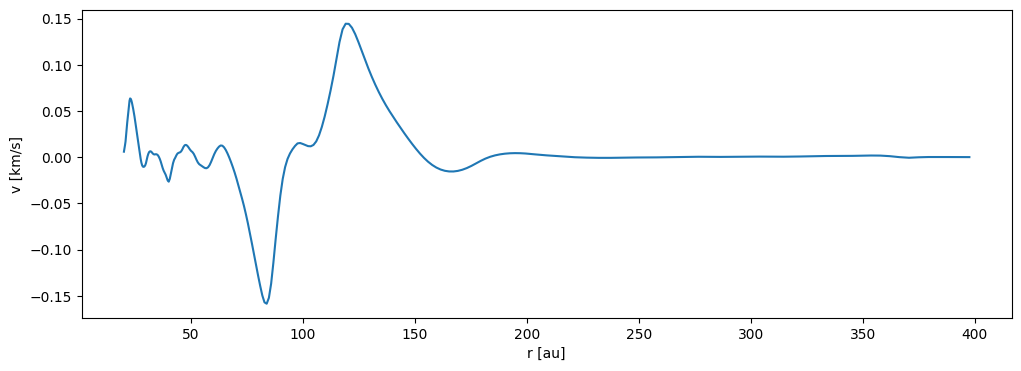

In [5]:

rr = data.coords['sph_r'].to('au').value

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(rr, v_phi - vkep)
ax.set_xlabel('r [au]')
ax.set_ylabel('v [km/s]')
plt.show()

## Run RT

In [5]:
rt_command = f"module load radmc3d; which radmc3d; radmc3d mctherm setthreads {rt_params['threads']};"
subprocess.run(["/bin/bash", "-c", rt_command], check=True, universal_newlines=True)

rt_command = f"module load radmc3d; radmc3d image iline {rt_params['iline']} widthkms {rt_params['widthkms']} linenlam {rt_params['linenlam']} vkms {rt_params['vkms']} npix {rt_params['npix']} incl {rt_params['incl']} posang {rt_params['posang']} dpc {rt_params['dpc']} sizeau {rt_params['sizeau']} phi {rt_params['phi']} setthreads {rt_params['threads']};"
subprocess.run(["/bin/bash", "-c", rt_command], check=True, universal_newlines=True)

print("\nAll done!")


*****************************************************
|             GCC 8.4.0 Module Loaded               |
|            support: gcc, g++, gfortran            |
*****************************************************


*****************************************************
|             RADMC-3D 2.0 Module Loaded            |
*****************************************************


Loading radmc3d/2.0
  Loading requirement: gcc/8.4.0


/cluster/software/src/radmc3d/2.0/bin/radmc3d
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                           


*****************************************************
|             GCC 8.4.0 Module Loaded               |
|            support: gcc, g++, gfortran            |
*****************************************************


*****************************************************
|             RADMC-3D 2.0 Module Loaded            |
*****************************************************


Loading radmc3d/2.0
  Loading requirement: gcc/8.4.0


 Grid information (current status):
   We have 2949120 branches, of which 2949120 are actual grid cells.
   ---> 100.000% mem use for branches, and 100.000% mem use for actual cells.
   No grid refinement is active. The AMR tree is not allocated (this saves memory).
 Reading the heat source spatial distribution...
 Using mirror symmetry in equatorial plane, because max(theta)==pi/2.
 Starting procedure for rendering image...
   --> Including dust
   --> Including lines
       No gas continuum included...
 Using Gaussian line profile
 Reading line data...
 NOTE: In lines.inp for molecule 1 no collision partners specified, therefore no non-LTE possible.
 Reading line data of molecule c18o ...
 Reading molecular/atomic number densities...
 Reading gas species number densities...
 Reading dust data...
 Reading dust densities...
 Dust mass total =    1.6549479637720393E-004  Msun
 Reading dust temperatures...
 Using dust temperature as gas temperature...
 Reading or computing partition func

## FITS & Convolution

In [ ]:
# subprocess.run(["/bin/bash", "-c", "cd ../scripts; ./fits_and_conv.sh"], check=True, universal_newlines=True)